In [2]:
import json
import random
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display

try:
    import cv2
    HAS_CV2 = True
except Exception:
    HAS_CV2 = False


In [3]:

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)


BASE_DIR = Path().resolve().parent 
DATA_DIR = BASE_DIR / "data"
IMG_TRAIN_DIR = DATA_DIR / "images" / "train"
IMG_VAL_DIR   = DATA_DIR / "images" / "val"
ANN_DIR       = DATA_DIR / "annotations"

TRAIN_JSON = ANN_DIR / "instances_train.json"
VAL_JSON   = ANN_DIR / "instances_val.json"

print("BASE_DIR:", BASE_DIR)
print("TRAIN_JSON exists:", TRAIN_JSON.exists())
print("VAL_JSON exists:", VAL_JSON.exists())
print("IMG_TRAIN_DIR exists:", IMG_TRAIN_DIR.exists())
print("IMG_VAL_DIR exists:", IMG_VAL_DIR.exists())
print("HAS_CV2:", HAS_CV2)

assert TRAIN_JSON.exists() and VAL_JSON.exists(), "Missing COCO json files"
assert IMG_TRAIN_DIR.exists() and IMG_VAL_DIR.exists(), "Missing image directories"


BASE_DIR: /Users/tomeratia/Desktop/לימודים/תואר ראשון/שנה ג/Gen Ai/StormVision
TRAIN_JSON exists: True
VAL_JSON exists: True
IMG_TRAIN_DIR exists: True
IMG_VAL_DIR exists: True
HAS_CV2: True


In [4]:
def load_coco(json_path: Path):
    with open(json_path, "r") as f:
        coco = json.load(f)
    images_df = pd.DataFrame(coco.get("images", []))
    ann_df    = pd.DataFrame(coco.get("annotations", []))
    cats_df   = pd.DataFrame(coco.get("categories", []))
    return coco, images_df, ann_df, cats_df

def basic_sanity(images_df: pd.DataFrame, ann_df: pd.DataFrame):
    out = {}
    out["n_images"] = int(len(images_df))
    out["n_annotations"] = int(len(ann_df))
    if "id" in images_df.columns:
        out["unique_image_ids"] = int(images_df["id"].nunique())
        out["image_id_unique_ok"] = (out["unique_image_ids"] == out["n_images"])
    else:
        out["unique_image_ids"] = None
        out["image_id_unique_ok"] = None

    if (not ann_df.empty) and ("image_id" in ann_df.columns) and ("id" in images_df.columns):
        out["ann_image_id_in_images_ratio"] = float(ann_df["image_id"].isin(images_df["id"]).mean())
    else:
        out["ann_image_id_in_images_ratio"] = None
    return out

def file_exists_ratio(images_df: pd.DataFrame, img_dir: Path, file_col="file_name"):
    if images_df.empty or file_col not in images_df.columns:
        return None
    paths = images_df[file_col].astype(str).apply(lambda x: img_dir / x)
    exists = paths.apply(lambda p: p.exists())
    return float(exists.mean())

coco_train, images_train_df, ann_train_df, cats_train_df = load_coco(TRAIN_JSON)
coco_val,   images_val_df,   ann_val_df,   cats_val_df   = load_coco(VAL_JSON)

print("COCO keys (train):", list(coco_train.keys()))
print("Sanity (train):", basic_sanity(images_train_df, ann_train_df))
print("File exists ratio (train):", file_exists_ratio(images_train_df, IMG_TRAIN_DIR))

print("Sanity (val):", basic_sanity(images_val_df, ann_val_df))
print("File exists ratio (val):", file_exists_ratio(images_val_df, IMG_VAL_DIR))

display(cats_train_df.sort_values("id").reset_index(drop=True))
display(images_train_df.head())
display(ann_train_df.head())


COCO keys (train): ['info', 'licenses', 'categories', 'images', 'annotations']
Sanity (train): {'n_images': 8930, 'n_annotations': 57760, 'unique_image_ids': 8930, 'image_id_unique_ok': True, 'ann_image_id_in_images_ratio': 1.0}
File exists ratio (train): 1.0
Sanity (val): {'n_images': 1547, 'n_annotations': 9630, 'unique_image_ids': 1547, 'image_id_unique_ok': True, 'ann_image_id_in_images_ratio': 1.0}
File exists ratio (val): 1.0


supercategory  id                    name
0       ignored   0                 ignored
1        person   1                 swimmer
2          boat   2                    boat
3          boat   3                  jetski
4        object   4  life_saving_appliances
5        object   5                    buoy

id file_name  height  width  \
0  3388  3388.jpg    2160   3840   
1  3389  3389.jpg    2160   3840   
2  3390  3390.jpg    2160   3840   
3  3391  3391.jpg    2160   3840   
4  3392  3392.jpg    2160   3840   

                                              source  \
0  {'drone': 'mavic', 'folder_name': 'DJI_0032', ...   
1  {'drone': 'mavic', 'folder_name': 'DJI_0032', ...   
2  {'drone': 'mavic', 'folder_name': 'DJI_0032', ...   
3  {'drone': 'mavic', 'folder_name': 'DJI_0032', ...   
4  {'drone': 'mavic', 'folder_name': 'DJI_0032', ...   

                    date_time  \
0         2020-08-25T14:16:21   
1  2020-08-25T14:16:21.467133   
2  2020-08-25T14:16:21.967633   
3  2020-08-25T14:16:22.468133   
4  2020-08-25T14:16:22.968633   

                                                meta frame  
0  {'image_name': 'DJI_0032_merged.MP4_image0.png...   NaN  
1  {'image_name': 'DJI_0032_merged.MP4_image0.png...   NaN  
2  {'image_name': 'DJI_0032_merged.MP4_image0.png...   NaN  
3  {'image_name': 'DJI_0032_merged.MP4_image0.png...   NaN  
4  {'image_name': 'DJI_0032_merged.MP4_image13.pn...   NaN

id  image_id                  bbox  area  category_id
0  14579      3388  [3619, 1409, 75, 38]  2850            2
1  14581      3389  [3524, 1408, 73, 37]  2701            2
2  14583      3390  [3399, 1406, 71, 36]  2556            2
3  14585      3391  [3267, 1152, 70, 35]  2450            2
4  14587      3392   [3053, 784, 65, 33]  2145            2

In [5]:
def infer_target_category_ids(cats_df: pd.DataFrame, target_names=("person", "swimmer", "human")):
    if cats_df is None or cats_df.empty or "name" not in cats_df.columns or "id" not in cats_df.columns:
        return set()
    names = cats_df["name"].astype(str).str.lower()
    hits = cats_df[names.isin(set(target_names))]
    return set(hits["id"].astype(int).tolist())

target_ids_train = infer_target_category_ids(cats_train_df, target_names=("person", "swimmer", "human"))
target_ids_val   = infer_target_category_ids(cats_val_df,   target_names=("person", "swimmer", "human"))

print("Target category ids (train):", target_ids_train)
print("Target category ids (val):", target_ids_val)

assert len(target_ids_train) > 0, "Could not detect target category in train"
assert len(target_ids_val) > 0, "Could not detect target category in val"


Target category ids (train): {1}
Target category ids (val): {1}


In [6]:
def build_image_level_df(images_df: pd.DataFrame, ann_df: pd.DataFrame, positive_category_ids: set):
    required = {"id", "file_name", "height", "width"}
    missing = required - set(images_df.columns)
    if missing:
        raise ValueError(f"images_df missing columns: {missing}")

    if ann_df.empty:
        ann_df = pd.DataFrame(columns=["image_id", "category_id", "bbox"])

    if {"image_id", "category_id", "bbox"}.issubset(ann_df.columns):
        pos_ann = ann_df[ann_df["category_id"].isin(positive_category_ids)].copy()
    else:
        pos_ann = pd.DataFrame(columns=["image_id", "category_id", "bbox"])

    boxes_per_image = (
        pos_ann.groupby("image_id")["bbox"]
        .apply(list)
        .reset_index()
        .rename(columns={"bbox": "bboxes"})
    )

    image_level = images_df.merge(boxes_per_image, left_on="id", right_on="image_id", how="left")
    image_level["has_person"] = image_level["bboxes"].notna().astype(int)
    image_level = image_level.drop(columns=["image_id"], errors="ignore")

    cnt_per_image = (
        pos_ann.groupby("image_id")["category_id"]
        .size()
        .reset_index(name="persons_count")
    )

    image_df = (
        image_level
        .merge(cnt_per_image, left_on="id", right_on="image_id", how="left")
        .drop(columns=["image_id"], errors="ignore")
    )
    image_df["persons_count"] = image_df["persons_count"].fillna(0).astype(int)
    image_df["aspect_ratio"] = image_df["width"] / image_df["height"]
    return image_df[["id","file_name","height","width","has_person","persons_count","bboxes","aspect_ratio"]]

train_image_df = build_image_level_df(images_train_df, ann_train_df, target_ids_train)
val_image_df   = build_image_level_df(images_val_df,   ann_val_df,   target_ids_val)

print("train_image_df:", train_image_df.shape)
print("val_image_df:", val_image_df.shape)
display(train_image_df.head())
display(val_image_df.head())


train_image_df: (8930, 8)
val_image_df: (1547, 8)


id file_name  height  width  has_person  persons_count bboxes  \
0  3388  3388.jpg    2160   3840           0              0    NaN   
1  3389  3389.jpg    2160   3840           0              0    NaN   
2  3390  3390.jpg    2160   3840           0              0    NaN   
3  3391  3391.jpg    2160   3840           0              0    NaN   
4  3392  3392.jpg    2160   3840           0              0    NaN   

   aspect_ratio  
0      1.777778  
1      1.777778  
2      1.777778  
3      1.777778  
4      1.777778

id file_name  height  width  has_person  persons_count  \
0  3464  3464.jpg    2160   3840           1              1   
1  3465  3465.jpg    2160   3840           1              1   
2  3466  3466.jpg    2160   3840           1              1   
3  3467  3467.jpg    2160   3840           1              2   
4  3468  3468.jpg    2160   3840           1              2   

                                         bboxes  aspect_ratio  
0                      [[1698, 1619, 230, 164]]      1.777778  
1                      [[1692, 1553, 296, 196]]      1.777778  
2                      [[1724, 1491, 266, 132]]      1.777778  
3  [[195, 728, 27, 20], [1859, 1444, 181, 118]]      1.777778  
4  [[396, 741, 17, 13], [1880, 1399, 246, 141]]      1.777778

In [7]:
def split_summary(df: pd.DataFrame, split: str):
    total = len(df)
    pos = int((df["has_person"] == 1).sum())
    neg = int((df["has_person"] == 0).sum())
    return {
        "split": split,
        "n_images": total,
        "n_pos": pos,
        "n_neg": neg,
        "pos_ratio": float(pos / total) if total else 0.0,
        "mean_persons": float(df["persons_count"].mean()) if total else 0.0,
        "max_persons": int(df["persons_count"].max()) if total else 0,
        "mean_width": float(df["width"].mean()) if total else 0.0,
        "mean_height": float(df["height"].mean()) if total else 0.0,
        "mean_aspect": float(df["aspect_ratio"].mean()) if total else 0.0,
    }

summary_df = pd.DataFrame([
    split_summary(train_image_df, "train"),
    split_summary(val_image_df, "val"),
])
display(summary_df)

overlap_files = len(set(train_image_df["file_name"]) & set(val_image_df["file_name"]))
overlap_ids   = len(set(train_image_df["id"]) & set(val_image_df["id"]))
print("Leakage check (train vs val):")
print(" - file_name overlap:", overlap_files)
print(" - id overlap:", overlap_ids)

print("Train resolution stats:")
display(train_image_df[["width","height","aspect_ratio"]].describe())

print("Val resolution stats:")
display(val_image_df[["width","height","aspect_ratio"]].describe())


split  n_images  n_pos  n_neg  pos_ratio  mean_persons  max_persons  \
0  train      8930   6898   2032   0.772452      4.154087           12   
1    val      1547   1286    261   0.831286      4.011635           12   

    mean_width  mean_height  mean_aspect  
0  3529.816573  2158.643561     1.694931  
1  3562.857143  2171.840983     1.698750

Leakage check (train vs val):
 - file_name overlap: 0
 - id overlap: 0
Train resolution stats:


width       height  aspect_ratio
count  8930.000000  8930.000000   8930.000000
mean   3529.816573  2158.643561      1.694931
std    1059.025289   909.454279      0.221906
min    1225.000000   926.000000      0.665689
25%    3632.000000  2160.000000      1.777778
50%    3840.000000  2160.000000      1.777778
75%    3840.000000  2160.000000      1.777778
max    5456.000000  5456.000000      1.777778

Val resolution stats:


width       height  aspect_ratio
count  1547.000000  1547.000000   1547.000000
mean   3562.857143  2171.840983      1.698750
std    1033.823971   891.586662      0.217392
min    1229.000000   932.000000      0.665689
25%    3840.000000  2160.000000      1.777778
50%    3840.000000  2160.000000      1.777778
75%    3840.000000  2160.000000      1.777778
max    5456.000000  5456.000000      1.777778

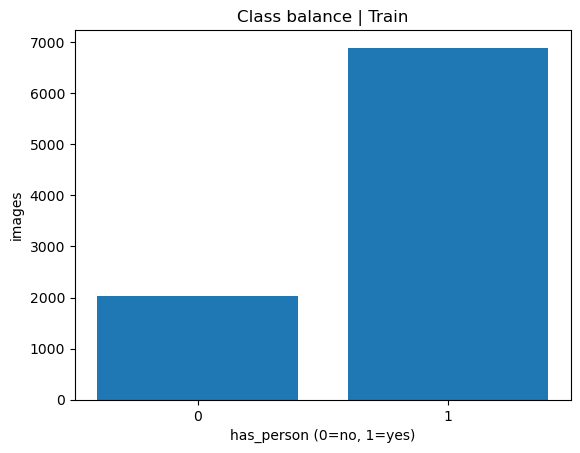

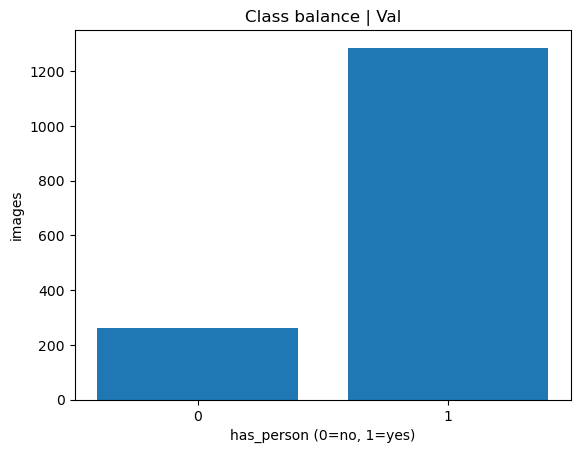

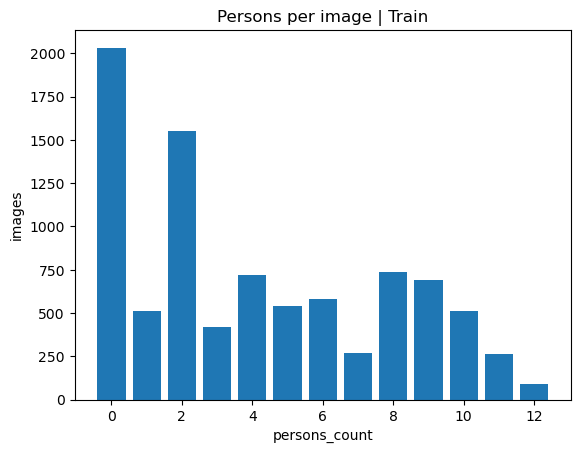

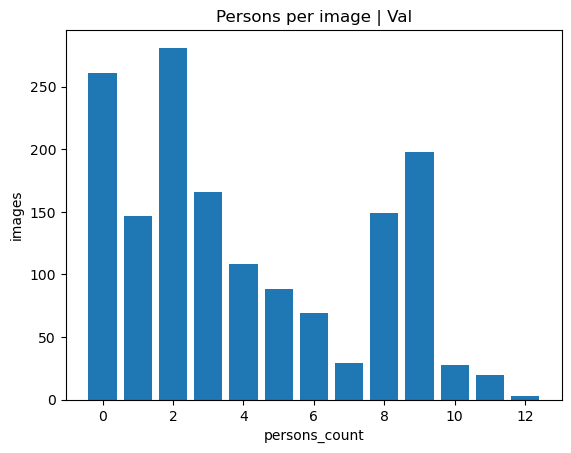

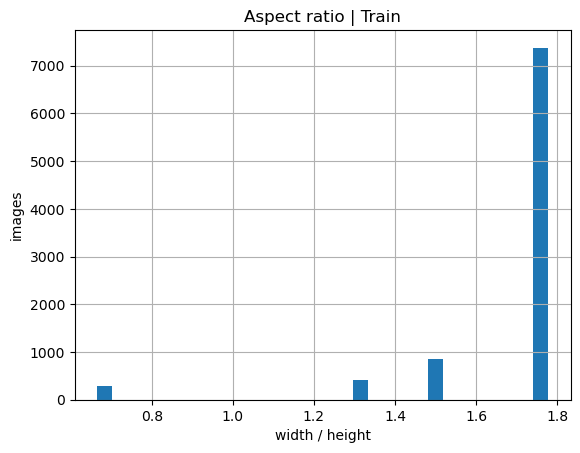

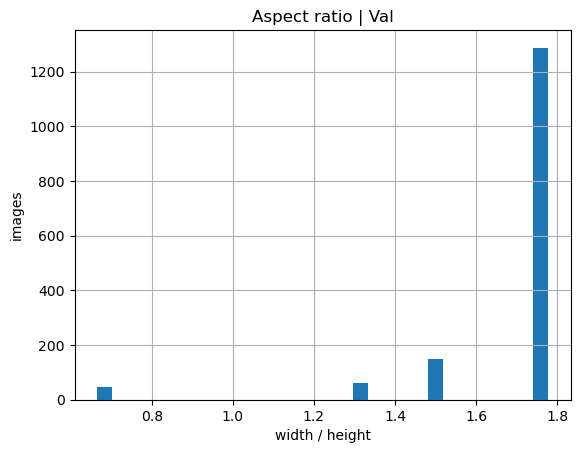

In [8]:
def plot_class_balance(df: pd.DataFrame, title: str):
    vc = df["has_person"].value_counts().sort_index()
    plt.figure()
    plt.bar(vc.index.astype(str), vc.values)
    plt.xlabel("has_person (0=no, 1=yes)")
    plt.ylabel("images")
    plt.title(title)
    plt.show()

def plot_persons_count(df: pd.DataFrame, title: str, cap: int = 15):
    vc = df["persons_count"].value_counts().sort_index()
    if not vc.empty and vc.index.max() > cap:
        high = vc[vc.index > cap].sum()
        vc = vc[vc.index <= cap]
        vc.loc[cap + 1] = high
        xlabel = f"persons_count (>{cap} grouped at {cap+1})"
    else:
        xlabel = "persons_count"

    plt.figure()
    plt.bar(vc.index.astype(int), vc.values)
    plt.xlabel(xlabel)
    plt.ylabel("images")
    plt.title(title)
    plt.show()

def plot_aspect_ratio(df: pd.DataFrame, title: str, bins: int = 30):
    plt.figure()
    df["aspect_ratio"].hist(bins=bins)
    plt.xlabel("width / height")
    plt.ylabel("images")
    plt.title(title)
    plt.show()

plot_class_balance(train_image_df, "Class balance | Train")
plot_class_balance(val_image_df,   "Class balance | Val")

plot_persons_count(train_image_df, "Persons per image | Train")
plot_persons_count(val_image_df,   "Persons per image | Val")

plot_aspect_ratio(train_image_df, "Aspect ratio | Train")
plot_aspect_ratio(val_image_df,   "Aspect ratio | Val")


Positive samples (train):


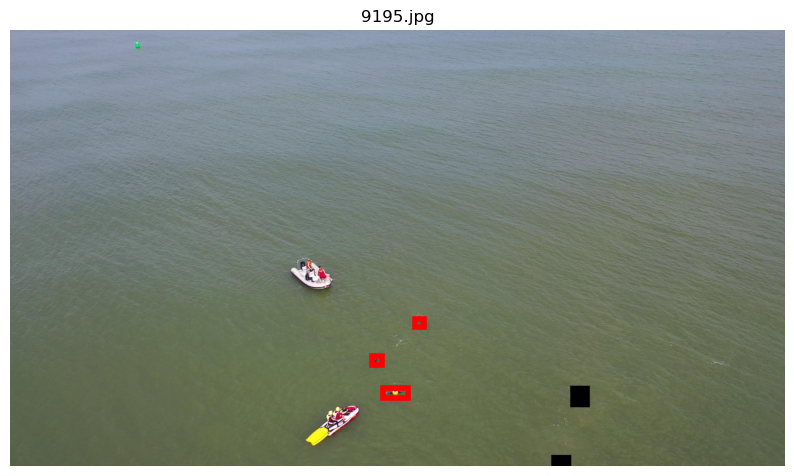

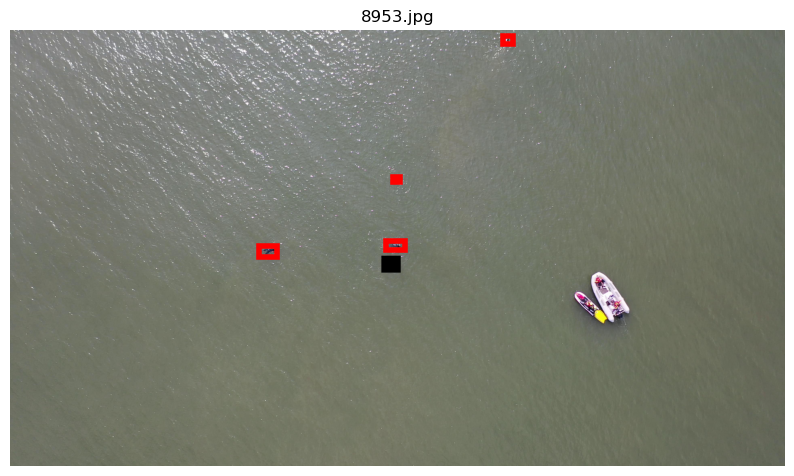

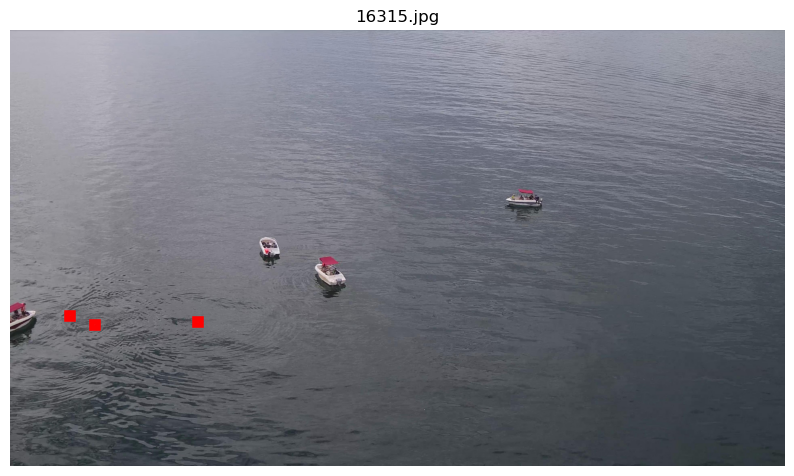

Negative samples (train):


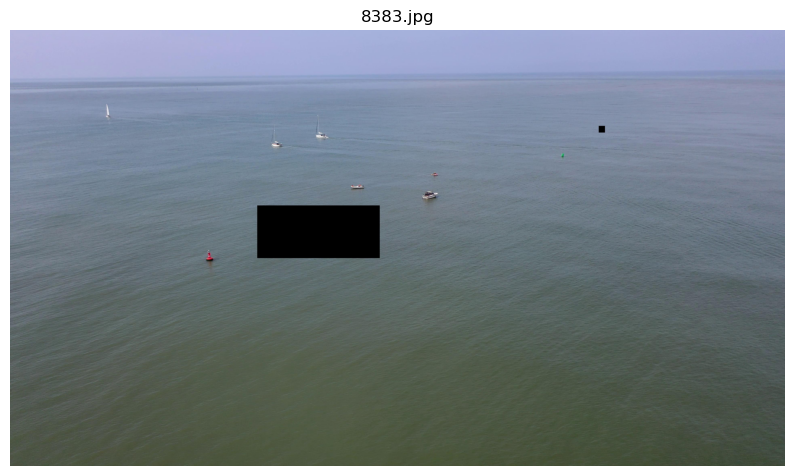

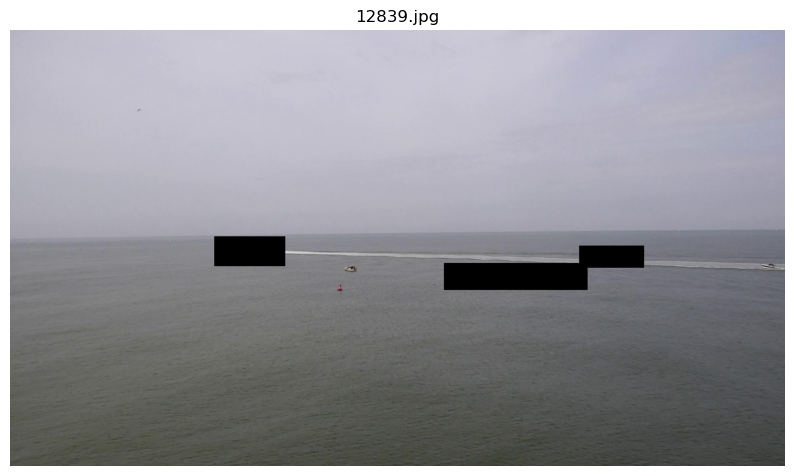

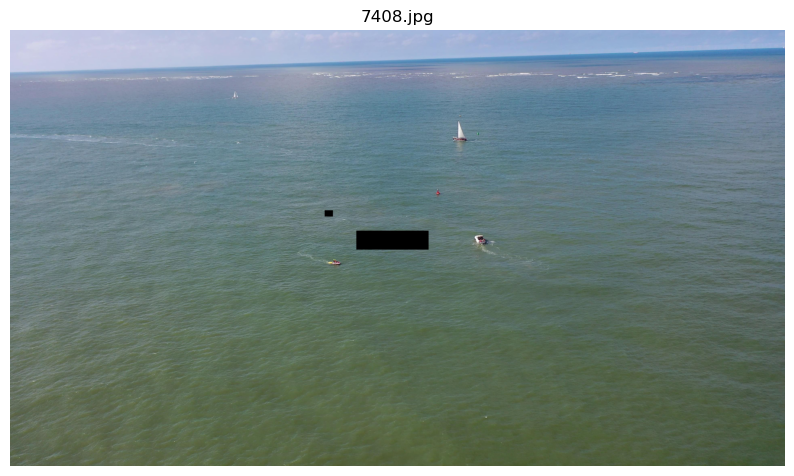

In [9]:
def show_image_with_boxes(row, img_dir: Path, figsize=(10, 6), linewidth=3):
    img_path = img_dir / str(row["file_name"])
    if not img_path.exists():
        print("Missing:", img_path)
        return
    img = Image.open(img_path).convert("RGB")

    plt.figure(figsize=figsize)
    plt.imshow(img)

    bboxes = row["bboxes"] if isinstance(row.get("bboxes", None), list) else []
    ax = plt.gca()
    for bbox in bboxes:
        x, y, w, h = bbox
        rect = plt.Rectangle((x, y), w, h, fill=False, linewidth=linewidth, edgecolor="red")
        ax.add_patch(rect)

    ax.axis("off")
    plt.title(str(row["file_name"]))
    plt.show()

pos_train = train_image_df[train_image_df["has_person"] == 1].sample(3, random_state=RANDOM_SEED)
neg_train = train_image_df[train_image_df["has_person"] == 0].sample(3, random_state=RANDOM_SEED)

print("Positive samples (train):")
for _, r in pos_train.iterrows():
    show_image_with_boxes(r, IMG_TRAIN_DIR, linewidth=4)

print("Negative samples (train):")
for _, r in neg_train.iterrows():
    rr = r.copy()
    rr["bboxes"] = []
    show_image_with_boxes(rr, IMG_TRAIN_DIR, linewidth=2)


BBox sanity (train): {'n_bboxes': 37096, 'invalid_wh': 0, 'out_of_bounds': 0, 'pct_tiny_<0.001': 90.84, 'pct_tiny_<0.0005': 78.58, 'median_rel_area': 0.00019169560185185186}
BBox sanity (val): {'n_bboxes': 6206, 'invalid_wh': 0, 'out_of_bounds': 0, 'pct_tiny_<0.001': 87.54, 'pct_tiny_<0.0005': 72.69, 'median_rel_area': 0.00024402006172839506}


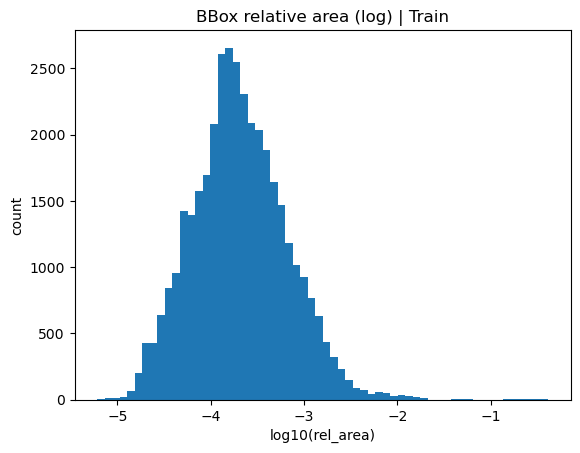

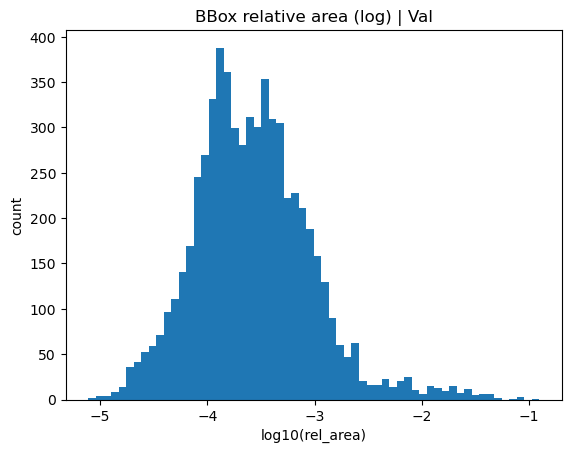

In [10]:
def explode_bboxes(image_df: pd.DataFrame):
    df = image_df[image_df["has_person"] == 1].copy()
    df = df.explode("bboxes").dropna(subset=["bboxes"])
    if df.empty:
        return pd.DataFrame()

    arr = np.vstack(df["bboxes"].apply(lambda b: np.array(b, dtype=float)).values)
    df["x"] = arr[:, 0]
    df["y"] = arr[:, 1]
    df["bw"] = arr[:, 2]
    df["bh"] = arr[:, 3]

    df["rel_area"] = (df["bw"] * df["bh"]) / (df["width"] * df["height"])
    df["bbox_aspect"] = df["bw"] / np.clip(df["bh"], 1e-9, None)

    cx = df["x"] + df["bw"] / 2.0
    cy = df["y"] + df["bh"] / 2.0
    df["cx_rel"] = cx / df["width"]
    df["cy_rel"] = cy / df["height"]
    return df

def bbox_sanity_report(bbox_df: pd.DataFrame):
    if bbox_df.empty:
        return {"n_bboxes": 0}
    x2 = bbox_df["x"] + bbox_df["bw"]
    y2 = bbox_df["y"] + bbox_df["bh"]
    invalid_wh = int(((bbox_df["bw"] <= 0) | (bbox_df["bh"] <= 0)).sum())
    out_of_bounds = int(((bbox_df["x"] < 0) | (bbox_df["y"] < 0) | (x2 > bbox_df["width"]) | (y2 > bbox_df["height"])).sum())
    tiny_001 = float((bbox_df["rel_area"] < 0.001).mean())
    tiny_0005 = float((bbox_df["rel_area"] < 0.0005).mean())
    return {
        "n_bboxes": int(len(bbox_df)),
        "invalid_wh": invalid_wh,
        "out_of_bounds": out_of_bounds,
        "pct_tiny_<0.001": round(100*tiny_001, 2),
        "pct_tiny_<0.0005": round(100*tiny_0005, 2),
        "median_rel_area": float(bbox_df["rel_area"].median()),
    }

train_bbox_df = explode_bboxes(train_image_df)
val_bbox_df   = explode_bboxes(val_image_df)

print("BBox sanity (train):", bbox_sanity_report(train_bbox_df))
print("BBox sanity (val):",   bbox_sanity_report(val_bbox_df))

def plot_bbox_rel_area_log(bbox_df: pd.DataFrame, title: str, bins: int = 60):
    if bbox_df.empty:
        return
    x = np.log10(np.clip(bbox_df["rel_area"].values, 1e-12, None))
    plt.figure()
    plt.hist(x, bins=bins)
    plt.xlabel("log10(rel_area)")
    plt.ylabel("count")
    plt.title(title)
    plt.show()

plot_bbox_rel_area_log(train_bbox_df, "BBox relative area (log) | Train")
plot_bbox_rel_area_log(val_bbox_df,   "BBox relative area (log) | Val")


Processed 200/800
Processed 400/800
Processed 600/800
Processed 800/800
Processed 200/400
Processed 400/400


split  has_person    n  mean_black  pct_has_block
0  train           0  179     0.02276          18.99
1  train           1  621     0.00366           9.02
2    val           0   62     0.01341          27.42
3    val           1  338     0.00152           4.14

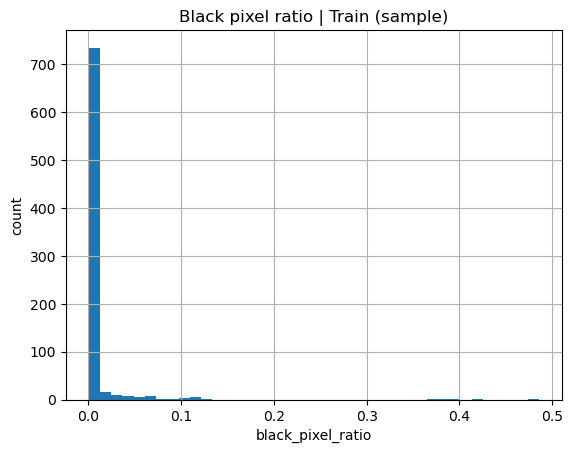

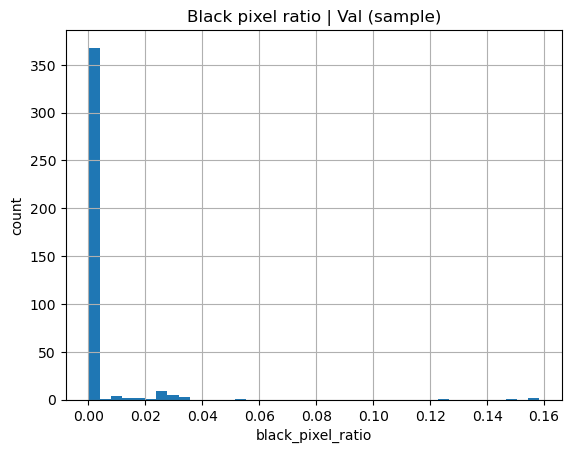

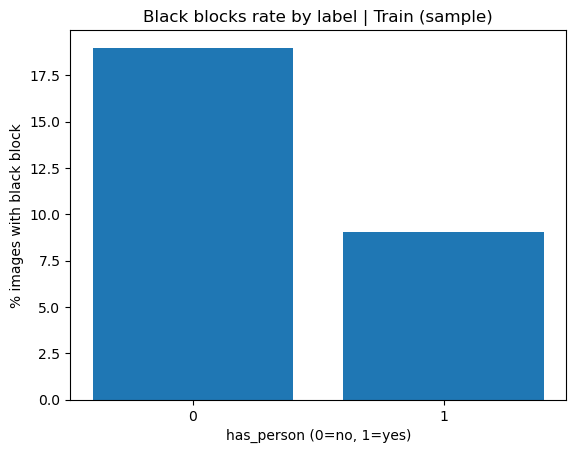

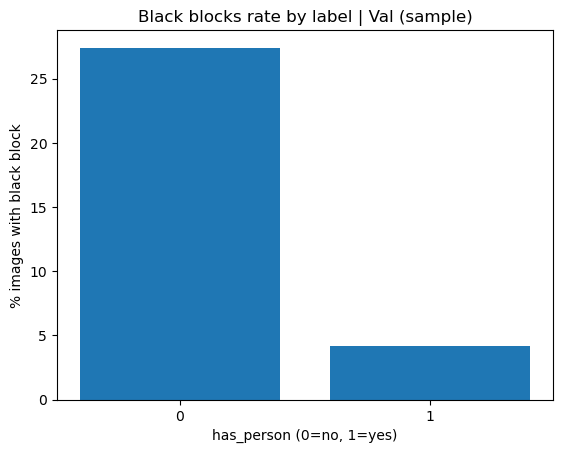

In [11]:
ENABLE_BLACK_BLOCK_CHECK = True

if ENABLE_BLACK_BLOCK_CHECK:
    def load_gray_fast(img_path):
        if HAS_CV2:
            return cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        return np.array(Image.open(img_path).convert("L"))

    def resize_gray(gray, resize_w=640):
        h, w = gray.shape[:2]
        if w <= resize_w:
            return gray, 1.0
        scale = resize_w / w
        new_h = max(1, int(h * scale))
        if HAS_CV2:
            small = cv2.resize(gray, (resize_w, new_h), interpolation=cv2.INTER_AREA)
        else:
            small = np.array(Image.fromarray(gray).resize((resize_w, new_h)))
        return small, scale

    def largest_component_ratio(mask01):
        if mask01 is None or mask01.size == 0:
            return 0.0
        if not HAS_CV2:
            return float(mask01.mean())
        m = (mask01 * 255).astype(np.uint8)
        num_labels, _, stats, _ = cv2.connectedComponentsWithStats(m, connectivity=8)
        if num_labels <= 1:
            return 0.0
        areas = stats[1:, cv2.CC_STAT_AREA]
        return float(areas.max() / mask01.size)

    def compute_black_block_metrics_sample(image_df, img_dir, thr=12, min_block_ratio=0.005, sample_n=600, resize_w=640):
        df = image_df.sample(min(sample_n, len(image_df)), random_state=RANDOM_SEED).reset_index(drop=True)
        rows = []
        for i, r in enumerate(df.itertuples(index=False), start=1):
            img_path = img_dir / str(r.file_name)
            if not img_path.exists():
                continue

            gray = load_gray_fast(img_path)
            gray_small, _ = resize_gray(gray, resize_w=resize_w)

            bm = (gray_small <= thr).astype(np.uint8)
            black_ratio = float(bm.mean())
            max_comp_ratio = float(largest_component_ratio(bm))
            has_block = int(max_comp_ratio >= min_block_ratio)

            rows.append({
                "has_person": int(r.has_person),
                "black_pixel_ratio": black_ratio,
                "max_black_component_ratio": max_comp_ratio,
                "has_black_block": has_block
            })

            if i % 200 == 0:
                print(f"Processed {i}/{len(df)}")

        return pd.DataFrame(rows)

    train_black = compute_black_block_metrics_sample(train_image_df, IMG_TRAIN_DIR, sample_n=800)
    val_black   = compute_black_block_metrics_sample(val_image_df,   IMG_VAL_DIR,   sample_n=400)

    def black_summary(metrics_df, split_name):
        g = (metrics_df
             .groupby("has_person")
             .agg(
                 n=("has_person", "count"),
                 mean_black=("black_pixel_ratio", "mean"),
                 pct_has_block=("has_black_block", "mean"),
             )
             .reset_index())
        g["split"] = split_name
        g["pct_has_block"] = (g["pct_has_block"] * 100).round(2)
        g["mean_black"] = g["mean_black"].round(5)
        return g[["split","has_person","n","mean_black","pct_has_block"]]

    display(pd.concat([black_summary(train_black,"train"), black_summary(val_black,"val")], ignore_index=True))

    def plot_black_ratio(metrics_df, title):
        plt.figure()
        metrics_df["black_pixel_ratio"].hist(bins=40)
        plt.xlabel("black_pixel_ratio")
        plt.ylabel("count")
        plt.title(title)
        plt.show()

    def plot_has_block_by_label(metrics_df, title):
        rate = metrics_df.groupby("has_person")["has_black_block"].mean() * 100
        plt.figure()
        plt.bar(rate.index.astype(str), rate.values)
        plt.xlabel("has_person (0=no, 1=yes)")
        plt.ylabel("% images with black block")
        plt.title(title)
        plt.show()

    plot_black_ratio(train_black, "Black pixel ratio | Train (sample)")
    plot_black_ratio(val_black,   "Black pixel ratio | Val (sample)")
    plot_has_block_by_label(train_black, "Black blocks rate by label | Train (sample)")
    plot_has_block_by_label(val_black,   "Black blocks rate by label | Val (sample)")


In [12]:
train_pos = (train_image_df["has_person"] == 1).mean() * 100
val_pos   = (val_image_df["has_person"] == 1).mean() * 100

tiny_train_001  = (train_bbox_df["rel_area"] < 0.001).mean() * 100 if len(train_bbox_df) else None
tiny_train_0005 = (train_bbox_df["rel_area"] < 0.0005).mean() * 100 if len(train_bbox_df) else None

conclusions_df = pd.DataFrame([{
    "train_pos_%": train_pos,
    "val_pos_%": val_pos,
    "train_tiny_<0.001_%": tiny_train_001,
    "train_tiny_<0.0005_%": tiny_train_0005,
    "file_overlap_train_val": overlap_files,
    "id_overlap_train_val": overlap_ids,
}])


conclusions_df = conclusions_df.round({
    "train_pos_%": 2,
    "val_pos_%": 2,
    "train_tiny_<0.001_%": 2,
    "train_tiny_<0.0005_%": 2,
})

display(conclusions_df)


train_pos_%  val_pos_%  train_tiny_<0.001_%  train_tiny_<0.0005_%  \
0        77.25      83.13                90.84                 78.58   

   file_overlap_train_val  id_overlap_train_val  
0                       0                     0

IMG_TEST_DIR exists: True
Test images found: 4368
Test meta sample size: 300 (sampled from 4368)


file_name        width       height  aspect_ratio
count        300   300.000000   300.000000    300.000000
unique       300          NaN          NaN           NaN
top     2520.jpg          NaN          NaN           NaN
freq           1          NaN          NaN           NaN
mean         NaN  3501.556667  2167.543333      1.673375
std          NaN  1154.285330   963.191963      0.235617
min          NaN  1230.000000   932.000000      0.665689
25%          NaN  3632.000000  2160.000000      1.777778
50%          NaN  3840.000000  2160.000000      1.777778
75%          NaN  3840.000000  2160.000000      1.777778
max          NaN  5456.000000  5456.000000      1.777778

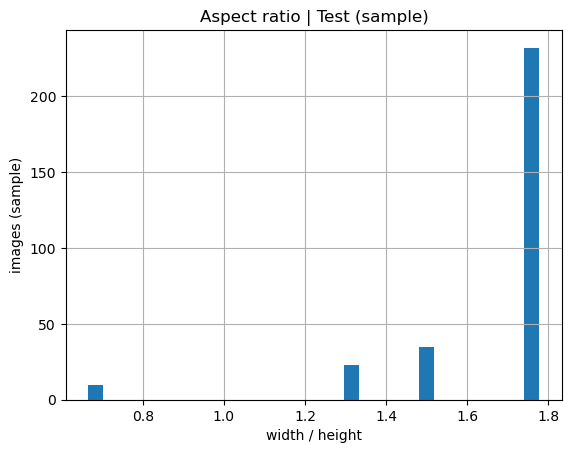

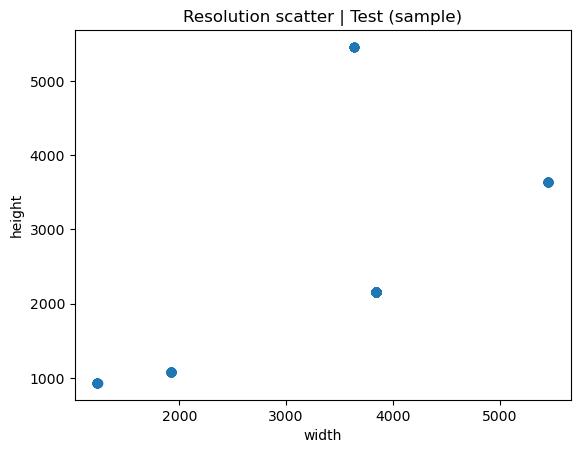

Random test images:


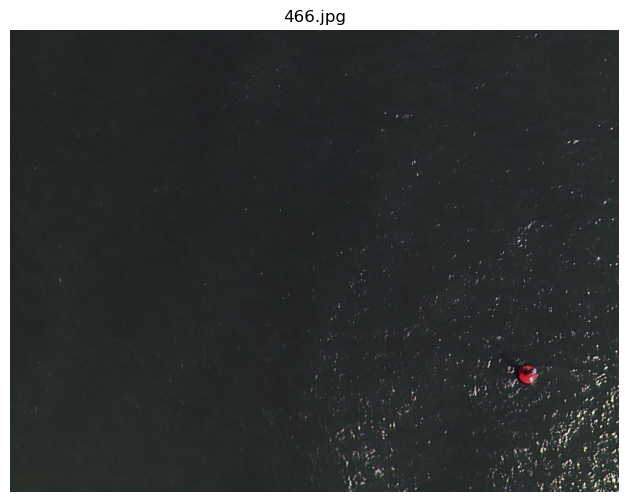

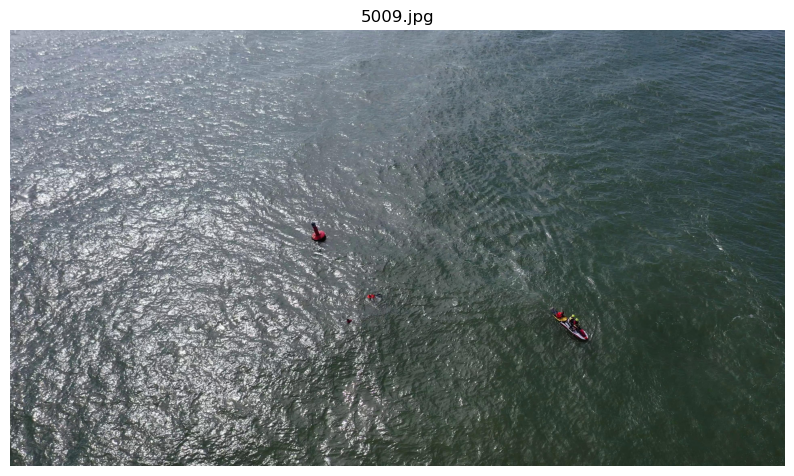

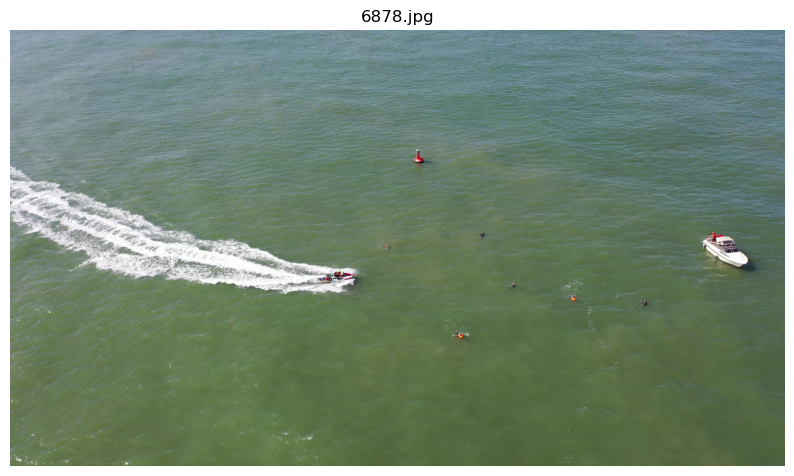

split     n    mean_w    mean_h  mean_aspect  median_aspect
0         train  8930  3529.817  2158.644        1.695          1.778
1           val  1547  3562.857  2171.841        1.699          1.778
2  test(sample)   300  3501.557  2167.543        1.673          1.778

In [13]:
# =========================
# Minimal TEST EDA (no labels / no json)
# =========================

IMG_TEST_DIR = DATA_DIR / "images" / "test"
print("IMG_TEST_DIR exists:", IMG_TEST_DIR.exists())

# Extensions
EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

def list_images(img_dir: Path, exts=EXTS):
    if not img_dir.exists():
        return []
    files = []
    for p in img_dir.rglob("*"):
        if p.is_file() and p.suffix.lower() in exts:
            files.append(p)
    return sorted(files)

test_files = list_images(IMG_TEST_DIR)

print(f"Test images found: {len(test_files)}")

# If no test folder or empty - stop quietly
if len(test_files) == 0:
    print("No test images to analyze (folder missing or empty).")
else:
    # Sample for fast stats 
    sample_n = min(300, len(test_files))
    rng = np.random.default_rng(RANDOM_SEED)
    sample_paths = rng.choice(test_files, size=sample_n, replace=False)

    def get_img_hw(path: Path):
        # PIL is enough here
        with Image.open(path) as im:
            w, h = im.size
        return w, h

    rows = []
    for p in sample_paths:
        try:
            w, h = get_img_hw(p)
            rows.append({"file_name": p.name, "width": w, "height": h, "aspect_ratio": w / h})
        except Exception:
            rows.append({"file_name": p.name, "width": None, "height": None, "aspect_ratio": None})

    test_meta_df = pd.DataFrame(rows)
    print(f"Test meta sample size: {len(test_meta_df)} (sampled from {len(test_files)})")
    display(test_meta_df.describe(include="all"))

    # Plot aspect ratio distribution (test)
    plt.figure()
    test_meta_df["aspect_ratio"].dropna().hist(bins=30)
    plt.xlabel("width / height")
    plt.ylabel("images (sample)")
    plt.title("Aspect ratio | Test (sample)")
    plt.show()

    # Plot resolution scatter (optional quick check)
    plt.figure()
    plt.scatter(test_meta_df["width"], test_meta_df["height"])
    plt.xlabel("width")
    plt.ylabel("height")
    plt.title("Resolution scatter | Test (sample)")
    plt.show()

    # Show a few random test images (no boxes)
    show_n = min(3, len(test_files))
    show_paths = rng.choice(test_files, size=show_n, replace=False)

    print("Random test images:")
    for p in show_paths:
        try:
            img = Image.open(p).convert("RGB")
            plt.figure(figsize=(10, 6))
            plt.imshow(img)
            plt.axis("off")
            plt.title(p.name)
            plt.show()
        except Exception as e:
            print("Failed to load:", p, "|", e)

    # Compare basic resolution/aspect between train/val vs test sample
    def summarize_split(df, name):
        return pd.Series({
            "split": name,
            "n": len(df),
            "mean_w": df["width"].mean(),
            "mean_h": df["height"].mean(),
            "mean_aspect": df["aspect_ratio"].mean(),
            "median_aspect": df["aspect_ratio"].median(),
        })

    # train/val already exist in your notebook
    train_basic = train_image_df[["width","height","aspect_ratio"]].copy()
    val_basic   = val_image_df[["width","height","aspect_ratio"]].copy()

    comp_df = pd.DataFrame([
        summarize_split(train_basic, "train"),
        summarize_split(val_basic, "val"),
        summarize_split(test_meta_df[["width","height","aspect_ratio"]].dropna(), "test(sample)"),
    ])
    comp_df = comp_df.round(3)
    display(comp_df)
